In [1]:
from comet_ml import Experiment
import comet_ml
from comet_ml.integration.pytorch import log_model
from libs import dataloader
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import mdmm


In [2]:
import zuko
from zuko.flows import Flow, UnconditionalDistribution, UnconditionalTransform
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.distributions import DiagNormal
from zuko.transforms import RotationTransform

In [93]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=600000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=100000, device="cuda")

# Create DataLoader
batch_size = 2048
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=True)

In [94]:
jets, lepton, met, full_mask, nu, W = dataset_train[0:1000]

In [ ]:
full_mask

Text(0.5, 0, 'nu phi normalized')

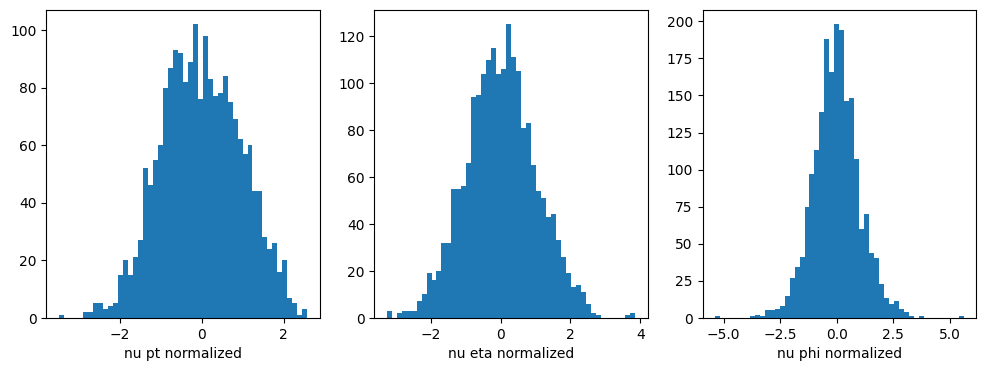

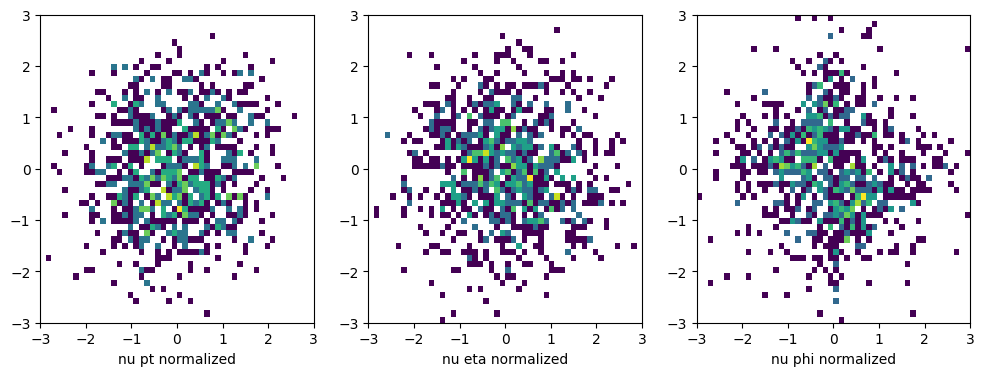

In [5]:
f, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist(nu.cpu().numpy()[:,:,0].flatten(), bins=50);
axs[0].set_xlabel("nu pt normalized")
axs[1].hist(nu.cpu().numpy()[:,:,1].flatten(), bins=50);
axs[1].set_xlabel("nu eta normalized")
axs[2].hist(nu.cpu().numpy()[:,:,2].flatten(), bins=50);
axs[2].set_xlabel("nu phi normalized")

f, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist2d(nu.cpu().numpy()[:,0,0].flatten(),
            nu.cpu().numpy()[:,1,0].flatten(), bins=50, range=((-3,3),(-3,3)), norm=LogNorm());
axs[0].set_xlabel("nu pt normalized")
axs[1].hist2d(nu.cpu().numpy()[:,0,1].flatten(),
            nu.cpu().numpy()[:,1,1].flatten(), bins=50,  range=((-3,3),(-3,3)),norm=LogNorm());
axs[1].set_xlabel("nu eta normalized")
axs[2].hist2d(nu.cpu().numpy()[:,0,2].flatten(),
            nu.cpu().numpy()[:,1,2].flatten(), bins=50,  range=((-3,3),(-3,3)), norm=LogNorm());
axs[2].set_xlabel("nu phi normalized")

# Transformer Encoder for Normalizing Flow context

In [5]:
from torch import nn
from torch.nn import TransformerEncoder,TransformerEncoderLayer
from libs.transformer_models import get_obj_type_tensor, count_parameters

class WWEncoder(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=16,
                 output_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()
        self.d_model = d_model
        
        self.transformer_enclayer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,batch_first=True)
        self.transformer_encoder = TransformerEncoder(self.transformer_enclayer, num_layers=num_encoder_layers, enable_nested_tensor=True)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model-1), # -1 to account for the additional label added to the features
            nn.SELU()
        )
        self.embedding_lep = nn.Sequential(
            nn.Linear(let_features, d_model-1),
            nn.SELU()
        )
        self.embedding_met = nn.Sequential(
            nn.Linear(met_features, d_model-1),
            nn.SELU()
        )

        # Building the accumulation net for the output of the encoder
        _layers = [nn.Linear(d_model, output_net[0]), nn.SELU()]
        for i in range(len(output_net)-1):
            _layers.append(nn.Linear(output_net[i], output_net[i+1]))
            _layers.append(nn.SELU())
            
        _layers.append(nn.Linear(output_net[-1], 1))
        _layers.append(nn.Sigmoid()) # to have a number between [0,1]
        self.output_network = nn.Sequential(*_layers)
        self.proj_out = nn.Linear(d_model, output_dim)

        self.register_buffer('obj_type', get_obj_type_tensor(max_njets))
        

    def forward(self, jets, leptons, met, full_mask):
        batch_size = jets.size(0)
        emb_jets = self.embedding_jets(jets)
        emb_lep = self.embedding_lep(leptons)
        emb_met = self.embedding_met(met)

        labels = self.obj_type.expand(batch_size, *list(self.obj_type.shape))
        
        emb = torch.cat([emb_jets, emb_lep, emb_met], dim=1)
        emb = torch.cat([emb, labels], dim=-1)

        # expanding the mask for lepton and met
        # the src_key_padding_mask needs to have True where the tokens are padded. 
        # Our full mask has 1 where the tokens are preset
        pad_mask = full_mask == 0
        out_transf = self.transformer_encoder(src=emb, src_key_padding_mask=pad_mask)
        score = self.output_network(out_transf)
        #Now using the score to accumulate the output
        # we need to mask the transformer encoder token that are padded
        out = torch.sum((out_transf * score * full_mask.unsqueeze(2)), axis=1)
        # Final projection
        out = self.proj_out(out)
        return out

In [7]:
# Example usage
d_model = 64
output_dim = 16
nhead = 4
num_encoder_layers = 2

model = WWEncoder(d_model, nhead, num_encoder_layers,
                   output_dim = output_dim,
                   output_net=[16])
model.to("cuda")
print(f"Model parameters: {count_parameters(model)}")

Model parameters: 251940


In [85]:
out = model(jets, lepton, met, full_mask)
print(out)

tensor([[-2.7342,  1.6769, -1.4094,  ...,  1.4483,  0.0734,  1.1522],
        [-3.7669, -0.3597, -0.7496,  ...,  1.5250, -0.7291, -0.4996],
        [-2.3214,  0.3863, -0.8347,  ...,  1.1761,  0.5143,  0.7442],
        ...,
        [-1.6595,  1.5646, -1.4095,  ...,  0.9041,  0.6028,  1.0566],
        [-2.2897,  0.3936, -0.8400,  ...,  1.1351, -0.0873,  0.6032],
        [-2.4493,  1.3622, -0.9508,  ...,  1.1171,  0.9398,  1.0771]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


We have obtained a dimension vector to be used as a conditioning input for the flow. 

Flow documentation: https://zuko.readthedocs.io/stable/api/zuko.flows.autoregressive.html#zuko.flows.autoregressive.MAF

In [29]:
flow = Flow(
    transform=[
        MaskedAutoregressiveTransform(features=6, context=16, hidden_features=(64, 64), passes=2),
        UnconditionalTransform(RotationTransform, torch.randn(6, 6)),
        MaskedAutoregressiveTransform(features=6, context=16, hidden_features=(64, 64), passes=2),
    ],
    base=UnconditionalDistribution(
        DiagNormal,
        torch.zeros(6),
        torch.ones(6),
        buffer=True,
    ),
)
flow.to("cuda")

Flow(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 0, 0, 1, 1, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=22, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=12, bias=True)
      )
    )
    (1): UnconditionalTransform(RotationTransform())
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 0, 0, 1, 1, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=22, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=12, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([6]), scale: torch.Size([6

In [23]:
out.shape

torch.Size([512, 16])

In [26]:
torch.reshape(nu, [nu.shape[0], 6])

tensor([[ 1.0956, -0.5457, -0.7255, -0.7780, -0.3499, -0.0506],
        [-0.5655, -0.7211, -1.5427, -0.9857,  1.0774,  0.1094],
        [ 1.7940, -1.2574, -0.7509, -0.3377,  0.8539,  1.0954],
        ...,
        [-0.5471,  0.4853,  0.5179,  0.8505,  0.0857, -1.5246],
        [-2.6939,  1.4918, -0.9217,  0.0967, -1.5091,  0.6099],
        [ 0.9458,  0.2069, -0.7960, -1.4522,  0.7643,  0.5420]],
       device='cuda:0')

In [31]:
log_prob = flow(out).log_prob(torch.reshape(nu, [nu.shape[0], 6]))

Text(0.5, 0, 'log(prob) of neutrinos')

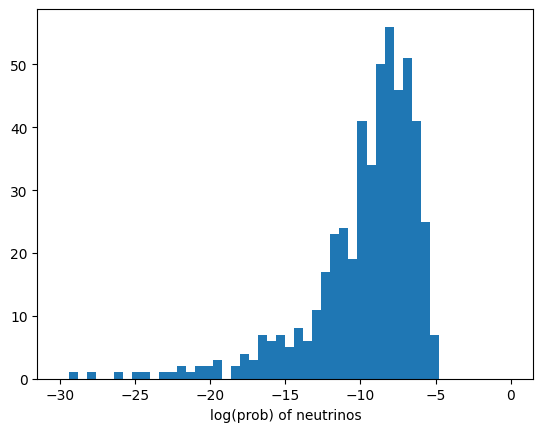

In [38]:
plt.hist(log_prob.cpu().detach().numpy(), bins=50, range=(-30, 0));
plt.xlabel("log(prob) of neutrinos")

## Full model

In [6]:
from torch import nn
from torch.nn import TransformerEncoder,TransformerEncoderLayer
from libs.transformer_models import get_obj_type_tensor, count_parameters

class NeutrinosFlow(nn.Module):
    
    def __init__(self, 
                 flow_nlayers=4, 
                 flow_hidden_net=(64,64),
                 flow_coupling=True,
                 d_model=128, 
                 nhead=8, 
                 num_encoder_layers=2, 
                 dim_feedforward=512,
                 context_dim=16,
                 context_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()

        self.encoder = WWEncoder(d_model=d_model,
                                 nhead=nhead, 
                                 num_encoder_layers=num_encoder_layers, 
                                 dim_feedforward=num_encoder_layers,
                                 output_dim=context_dim,
                                 output_net=context_net,
                                 jet_features = jet_features,
                                 let_features = let_features, 
                                 met_features = met_features,
                                 max_njets= max_njets)

        flow_transf_layers = []
        for i in range(flow_nlayers-1):
            flow_transf_layers.append(MaskedAutoregressiveTransform(features=6, 
                                                                    context=context_dim, 
                                                                    hidden_features=flow_hidden_net, 
                                                                    passes=2 if flow_coupling else None))
            # Let's add a rotation of the features
            flow_transf_layers.append(UnconditionalTransform(RotationTransform, torch.randn(6, 6)))
        # adding last transformation
        flow_transf_layers.append(MaskedAutoregressiveTransform(features=6, 
                                                                    context=context_dim, 
                                                                    hidden_features=flow_hidden_net, 
                                                                    passes=2 if flow_coupling else None))
  
        self.flow = Flow(
                transform=flow_transf_layers,
                base=UnconditionalDistribution(
                    DiagNormal,
                    torch.zeros(6),
                    torch.ones(6),
                    buffer=True,
                ),
            )

    def forward(self, jets, leptons, met, full_mask):
        conditioning_vector = self.encoder(jets, leptons, met, full_mask)
        # Our model returns a flow model with the correct conditioning
        return self.flow(conditioning_vector)

## Maximum likelihood training

In [7]:
def train_flow(model, device, loader, val_loader,  optimizer, epochs, experiment=None):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            optimizer.zero_grad()

            log_prob = model(jets,lepton,met, full_mask).log_prob(torch.reshape(nu, [nu.shape[0], 6]))
            loss = - log_prob.mean()
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}")
                if experiment:
                   experiment.log_metric("train_loss_step", loss.item(), step=batch_idx)
                    
            loss.backward()
            # for param in model.parameters():
            #     if param.grad is None:
            #         print(f"Parameter {param} has no gradient")
            #     elif torch.all(param.grad == 0):
            #         print(f"All elements of parameter {param} gradient are zero")
            #     else:
            #         print(f"Gradient of parameter {param} is non-zero")
            
            optimizer.step()
            
        # Log metrics
        if experiment:
            experiment.log_metric("train_loss_epoch", loss.item(), step=epoch)
        
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
       
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                
               flow_conditioned_val = model(jets_val,lepton_val, met_val, full_mask_val)
               log_prob_val = flow_conditioned_val.log_prob(torch.reshape(nu_val, [nu_val.shape[0], 6]))
               val_loss = - log_prob_val.mean()
            
            if experiment:
                experiment.log_metric("val_loss_epoch", val_loss.item(), step=epoch)
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}")

           
        print(f"End of epoch {epoch}")
    return model

In [8]:
# Example usage
d_model = 64
nhead = 8
num_encoder_layers = 4
flow_nlayers= 2
flow_hidden_net=(64,64)
context_net=[32,32]
flow_coupling=False
learning_rate = 1e-4
num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeutrinosFlow(d_model = d_model,
                    nhead = nhead,
                    num_encoder_layers = num_encoder_layers,
                    flow_nlayers=flow_nlayers ,
                    flow_hidden_net=flow_hidden_net,
                    flow_coupling=flow_coupling,
                     context_net=context_net)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"Model parameters: {count_parameters(model)}")

Model parameters: 105268


In [19]:
log_prob = model(jets,lepton,met, full_mask).log_prob(torch.reshape(nu, [nu.shape[0], 6]))
loss = - log_prob.mean()
print(loss)

tensor(5.1259, device='cuda:0', grad_fn=<NegBackward0>)


In [9]:
trained_model = train_flow(model, device, dataloader_train, dataloader_val, optimizer, num_epochs)

epoch 0, step 0, Loss: 8.6357
epoch 0, step 100, Loss: 8.0503
epoch 0, step 200, Loss: 7.6639
epoch 0, step 300, Loss: 7.5702
epoch 0, step 400, Loss: 7.4798
epoch 0, Validation Loss: 7.3911
End of epoch 0
epoch 1, step 0, Loss: 7.4764
epoch 1, step 100, Loss: 7.3665
epoch 1, step 200, Loss: 7.2520
epoch 1, step 300, Loss: 7.3005
epoch 1, step 400, Loss: 7.2139
epoch 1, Validation Loss: 7.2450
End of epoch 1
epoch 2, step 0, Loss: 7.1701
epoch 2, step 100, Loss: 7.1930
epoch 2, step 200, Loss: 7.2004
epoch 2, step 300, Loss: 7.0946
epoch 2, step 400, Loss: 6.9913
epoch 2, Validation Loss: 6.8830
End of epoch 2
epoch 3, step 0, Loss: 6.9835
epoch 3, step 100, Loss: 6.8768
epoch 3, step 200, Loss: 6.9235
epoch 3, step 300, Loss: 6.8952
epoch 3, step 400, Loss: 6.7752
epoch 3, Validation Loss: 6.7368
End of epoch 3
epoch 4, step 0, Loss: 6.7771
epoch 4, step 100, Loss: 6.8097
epoch 4, step 200, Loss: 6.7181
epoch 4, step 300, Loss: 6.6465
epoch 4, step 400, Loss: 6.6903
epoch 4, Validatio

In [ ]:
torch.save(model.state_dict(), "models/models_nuflow_coupling_v1.pt")

## Spline flow

In [18]:
from torch import nn
from torch.nn import TransformerEncoder,TransformerEncoderLayer
from libs.transformer_models import get_obj_type_tensor, count_parameters 

from zuko.flows.spline import NSF


class NeutrinosFlowSpline(nn.Module):
    
    def __init__(self, 
                 flow_nlayers=4, 
                 flow_hidden_net=(64,64),
                 flow_bins=8,
                 d_model=128, 
                 nhead=8, 
                 num_encoder_layers=2, 
                 dim_feedforward=512,
                 context_dim=16,
                 context_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()

        self.encoder = WWEncoder(d_model=d_model,
                                 nhead=nhead, 
                                 num_encoder_layers=num_encoder_layers, 
                                 dim_feedforward=num_encoder_layers,
                                 output_dim=context_dim,
                                 output_net=context_net,
                                 jet_features = jet_features,
                                 let_features = let_features, 
                                 met_features = met_features,
                                 max_njets= max_njets)

        self.flow = NSF(features=6, 
                        context=context_dim,
                        transforms=flow_nlayers,
                        bins=flow_bins, 
                        hidden_features=flow_hidden_net)

    def forward(self, jets, leptons, met, full_mask):
        conditioning_vector = self.encoder(jets, leptons, met, full_mask)
        # Our model returns a flow model with the correct conditioning
        return self.flow(conditioning_vector)

In [79]:
# Example usage
d_model = 64
nhead = 8
num_encoder_layers = 4
flow_nlayers= 4
flow_hidden_net=[128,128]
context_net=[64,32]
context_dim=16
flow_bins=8
learning_rate = 3e-4
num_epochs = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeutrinosFlowSpline(d_model = d_model,
                    nhead = nhead,
                    num_encoder_layers = num_encoder_layers,
                    context_dim = context_dim,
                    flow_nlayers=flow_nlayers ,
                    flow_hidden_net=flow_hidden_net,
                    flow_bins=flow_bins,
                     context_net=context_net)


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model.to(device)
print(f"Model parameters: {count_parameters(model)}")

Model parameters: 244544


In [80]:
trained_model = train_flow(model, device, dataloader_train, dataloader_val, optimizer, num_epochs)

epoch 0, step 0, Loss: 9.0110
epoch 0, step 100, Loss: 6.6875
epoch 0, step 200, Loss: 6.0150
epoch 0, Validation Loss: 5.6836
End of epoch 0
epoch 1, step 0, Loss: 5.6177
epoch 1, step 100, Loss: 5.5496
epoch 1, step 200, Loss: 5.2411
epoch 1, Validation Loss: 5.1549
End of epoch 1
epoch 2, step 0, Loss: 5.0671
epoch 2, step 100, Loss: 5.0629
epoch 2, step 200, Loss: 5.0104
epoch 2, Validation Loss: 4.8205
End of epoch 2
epoch 3, step 0, Loss: 4.9230
epoch 3, step 100, Loss: 4.7454
epoch 3, step 200, Loss: 4.7077
epoch 3, Validation Loss: 4.7260
End of epoch 3
epoch 4, step 0, Loss: 4.7561
epoch 4, step 100, Loss: 4.7296
epoch 4, step 200, Loss: 4.6410
epoch 4, Validation Loss: 4.6045
End of epoch 4
epoch 5, step 0, Loss: 4.6325
epoch 5, step 100, Loss: 4.6177
epoch 5, step 200, Loss: 4.5704
epoch 5, Validation Loss: 4.5696
End of epoch 5
epoch 6, step 0, Loss: 4.4420
epoch 6, step 100, Loss: 4.4966
epoch 6, step 200, Loss: 4.5547
epoch 6, Validation Loss: 4.4355
End of epoch 6
epoch 

In [81]:
torch.save(model.state_dict(), "models/models_nuflow_spline_v2.pt")

In [56]:
torch.cuda.empty_cache()

In [86]:
#def validate_flow(model, dataset_val):
Nsamples = 30000
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=Nsamples, device="cuda")

samples_all = torch.zeros(1, Nsamples,  6)
with torch.no_grad():
    for i in range(Nsamples // 100):
        jets, lepton, met, full_mask, nu, W = dataset_val[i*100:(i+1)*100]
        samples = model(jets,lepton,met, full_mask).rsample((1,))
        samples_all[0:, i*100:(i+1)*100] = samples.cpu()
        

In [87]:
nu_sampl = torch.reshape(samples_all, (Nsamples, 2, 3)).detach().cpu().numpy()
nu_true = dataset_val[0:Nsamples][4]

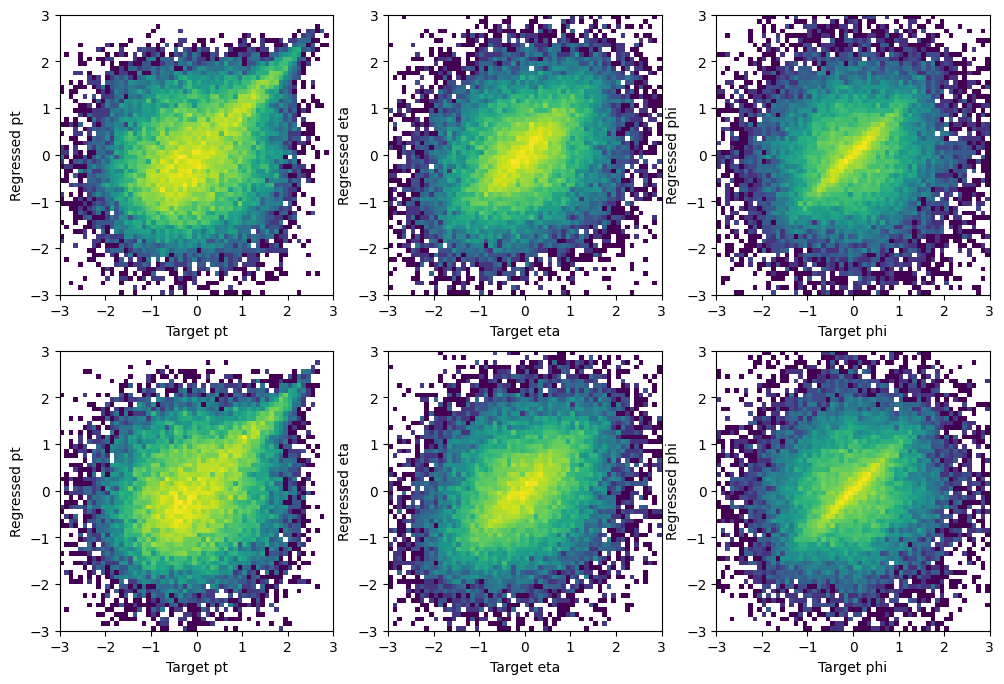

In [88]:
f1 , axs = plt.subplots(2, 3, figsize=(12, 8))
for i in range(2):
    for j in range(3):
        f = plt
        axs[i][j].hist2d(nu_sampl[:,i, j], nu_true[:,i, j].cpu().numpy(),
          bins=60, range=((-3,3),(-3,3)),
        norm=LogNorm())
        if j == 0:
            axs[i][j].set_xlabel("Target pt")
            axs[i][j].set_ylabel("Regressed pt")
        elif j == 1:
            axs[i][j].set_xlabel("Target eta")
            axs[i][j].set_ylabel("Regressed eta")
        elif j == 2:
            axs[i][j].set_xlabel("Target phi")
            axs[i][j].set_ylabel("Regressed phi")
        elif j == 3:
            axs[i][j].set_xlabel("Target mass")
            axs[i][j].set_ylabel("Regressed mass")

In [89]:
nu_scaling = np.load(f"{datafolder}/nu_data_scaling.npy")
nu_scaling

array([[ 4.56733229e+00,  1.18623630e+00],
       [-2.50588365e-03,  1.13991878e+00],
       [-1.19440530e-03,  1.81360673e+00]])

In [90]:
def logistic(x):
    return 1/(1+np.exp(-x))

def logit(x, clip=1e-6):
    x = np.clip(x, a_min=clip, a_max=1-clip)
    return np.log(x/(1-x))
    
def unscale_nu(nu):
    out = np.zeros(nu.shape)
    out[:,:,0] =   np.exp( (nu[:,:,0]*nu_scaling[0,1])+nu_scaling[0,0])-1
    out[:,:,1] =   (nu[:,:,1]*nu_scaling[1,1])+nu_scaling[1,0]
    out[:,:,2] =   (nu[:,:,2]*nu_scaling[2,1])+nu_scaling[2,0]
    out[:,:,2] =     logistic(out[:,:,2])*2*np.pi - np.pi
    return out

In [91]:
nu_sampl_unscaled = unscale_nu(nu_sampl)
nu_true_unscaled = unscale_nu(nu_true.cpu().numpy())

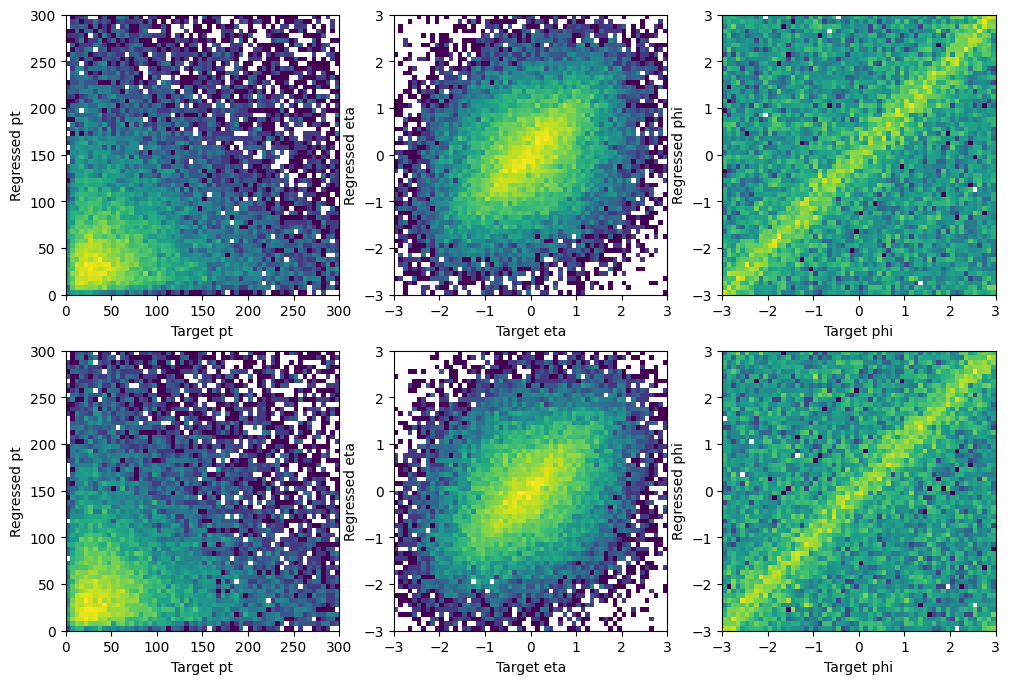

In [92]:
f1 , axs = plt.subplots(2, 3, figsize=(12, 8))
for i in range(2):
    for j in range(3):
        f = plt
        if j>=1:
            axs[i][j].hist2d(nu_sampl_unscaled[:,i, j], nu_true_unscaled[:,i, j],
                  bins=60, range=((-3,3),(-3,3)),
                norm=LogNorm())
        else:
            axs[i][j].hist2d(nu_sampl_unscaled[:,i, j], nu_true_unscaled[:,i, j],
              bins=60, range=((0,300),(0,300)),
            norm=LogNorm())
        if j == 0:
            axs[i][j].set_xlabel("Target pt")
            axs[i][j].set_ylabel("Regressed pt")
        elif j == 1:
            axs[i][j].set_xlabel("Target eta")
            axs[i][j].set_ylabel("Regressed eta")
        elif j == 2:
            axs[i][j].set_xlabel("Target phi")
            axs[i][j].set_ylabel("Regressed phi")
        elif j == 3:
            axs[i][j].set_xlabel("Target mass")
            axs[i][j].set_ylabel("Regressed mass")

The Flow has learnt to sample correctly the phi of the neutrino, the eta is starting to work, whereas the target pt is far from optimal.

# Pretraing the Transformer Encoder with a regression